In [158]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [159]:
# !pip install langchain
# ! pip install langchain_openai
# ! pip install langchain_huggingface
# ! pip install langgraph

In [160]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal, List, Optional
from pydantic import BaseModel, Field, field_validator, ValidationError

In [183]:
# here we are using those models only which support structured output
open_ai_api_key = 'your_api_key'
model = ChatOpenAI(model = 'gpt-4o-mini', api_key=open_ai_api_key)

In [162]:
class SentimentSchema(BaseModel):

    sentiment: Literal["pos", "neg"] = Field( description="Sentiment of the review.")

In [163]:
strutured_output = model.with_structured_output(SentimentSchema)

In [164]:
review = "Great UI of the page."

In [165]:
prompt = f"Find the sentiment of the following review: {review}"

output = strutured_output.invoke(prompt)

In [166]:
print(output)

sentiment='pos'


# LangGraph State Schema

In [167]:
# The overall state of the graph (this is the public state shared across nodes)
# pydantic state type

class ReviewState(BaseModel):

    review: str = Field( description="Sample review")
    sentiment: Literal["pos", "neg"] = Field( description="Sentiment of the review - positive or negative", default=None)
    diagnosis: dict = Field( description="Diagnosing why negative review", default=None)
    response: str = Field(description="Diagnosys response back", default=None)    

> # To create a field type of list of string from a specific set of words only.

In [168]:
ALLOWED_TONE = ["angry", "harsh", "frustrated", "disappointed", "calm", "sad",  "other"]

In [169]:
class DiagnosisSchema(BaseModel):

    issue_type: Literal["UX", "UI", "speed", "Latency", "Bug", "Support", "Security", "Other"] = Field(description="The issue type of the negative response")

    tone: List[str] = Field(description="tone types of the review")

    urgency: Literal["low", "medium", "high"]
    
    # if required list of str from a selected list of words only
    # @field_validator('tone')
    # @classmethod
    # def check_allowed(cls, v):
    #     invalid = [item for item in v if item not in ALLOWED_TONE]
    #     if invalid:
    #         raise ValueError(f"Invalid item(s): {invalid}. Allowed: {ALLOWED_TONE}")
    #     return v


# for diagnosis

In [170]:
diagnosis_response = model.with_structured_output(DiagnosisSchema)

In [171]:
def find_sentiment(state: ReviewState):

    prompt = f'Find the sentiment of the following review: {state.review}'

    output = strutured_output.invoke(prompt)

    sentiment = output.sentiment

    return {"sentiment": sentiment}

    

In [172]:
def positve_response(state: ReviewState):

    prompt = f'Write a warm message thanking for a positive review: {state.review}. Also ask the user to drop a feedback on the website.'
    positive_response = model.invoke(prompt).content
    
    return {"response": positive_response}

    

In [173]:
def negative_response(state: ReviewState):

    prompt = f'Create a response for the user based on the review : {state.review} and the following diagnosis of the review: {state.diagnosis}'

    negative_response = model.invoke(prompt).content

    return {"response": negative_response}
    

In [174]:
def run_diagnosis(state: ReviewState):

    prompt = f'Diagnose the negative review: {state.review}. Return issue_type, tone & urgency'

    response = diagnosis_response.invoke(prompt)

    return {"diagnosis": response.model_dump()}

# Conditional Check

In [175]:
def conditional_check(state: ReviewState) -> Literal["positve_response", "run_diagnosis"]:

    sentiment = state.sentiment

    if sentiment == "pos":

        return "positve_response"
    else:
        return "run_diagnosis"  
        

In [176]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positve_response", positve_response)
graph.add_node("negative_response", negative_response)
graph.add_node("run_diagnosis", run_diagnosis)


graph.add_edge(START, "find_sentiment")

graph.add_conditional_edges( "find_sentiment", conditional_check)

graph.add_edge("positve_response", END)

graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()


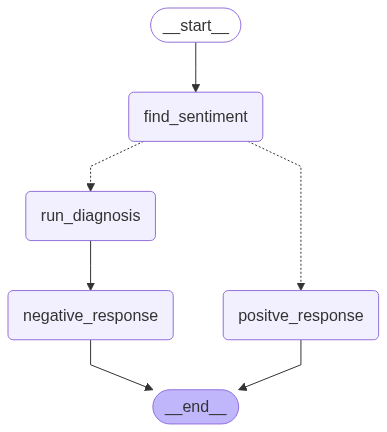

In [177]:
workflow

In [178]:
pos_review=""" TaskFlow has completely transformed how my team works. The interface is clean, intuitive, and lightning-fast. Features like real-time collaboration, smart task suggestions, and seamless integration with Google Calendar and Slack have boosted our productivity immensely. I especially love the automated workflow builder — it saves us hours every week. Whether you're managing a solo to-do list or coordinating across teams, TaskFlow makes it feel effortless. It’s clear the developers listen to user feedback — updates are frequent and meaningful. Highly recommend it for professionals and teams of all sizes! """

neg_review =""" TaskFlow is all hype with very little substance. The interface looks modern but is cluttered and confusing to navigate. Core features like recurring tasks and file attachments are either buggy or too limited. The mobile version is frustratingly slow and lacks key functionalities available on desktop. To make things worse, their customer support is unresponsive — I waited over a week for a reply to a simple billing issue. For a tool that claims to simplify productivity, TaskFlow ends up adding more stress than it removes. I switched to a competitor within days """

mix_review = """ TaskFlow has potential, but it’s not quite there yet. On the plus side, the collaboration tools and task management dashboard are genuinely useful. I like how easy it is to assign tasks, add deadlines, and monitor progress across teams. However, the app still feels half-baked in some areas — notifications are inconsistent, integrations sometimes break, and it’s missing essential features like time tracking or Gantt charts unless you upgrade to a pricey premium plan. If they iron out the bugs and expand the feature set, TaskFlow could become a serious contender in the productivity space. """

In [179]:
pos_input = {
    "review": pos_review
}

neg_input = {
    "review": neg_review
}

mix_input = {
    "review": mix_review
}

pos_output = workflow.invoke(pos_input)
neg_output = workflow.invoke(neg_input)
mix_output = workflow.invoke(mix_input)


# Positive review

In [180]:
print(pos_output)

{'review': " TaskFlow has completely transformed how my team works. The interface is clean, intuitive, and lightning-fast. Features like real-time collaboration, smart task suggestions, and seamless integration with Google Calendar and Slack have boosted our productivity immensely. I especially love the automated workflow builder — it saves us hours every week. Whether you're managing a solo to-do list or coordinating across teams, TaskFlow makes it feel effortless. It’s clear the developers listen to user feedback — updates are frequent and meaningful. Highly recommend it for professionals and teams of all sizes! ", 'sentiment': 'pos', 'response': "Subject: Thank You for Your Wonderful Review!\n\nDear [User's Name],\n\nThank you so much for taking the time to share your positive experience with TaskFlow! We’re thrilled to hear how our platform has transformed the way your team works. It’s feedback like yours that inspires us to continually improve and enhance our features.\n\nWe’re de

# Negative review

In [181]:
print(neg_output)

{'review': ' TaskFlow is all hype with very little substance. The interface looks modern but is cluttered and confusing to navigate. Core features like recurring tasks and file attachments are either buggy or too limited. The mobile version is frustratingly slow and lacks key functionalities available on desktop. To make things worse, their customer support is unresponsive — I waited over a week for a reply to a simple billing issue. For a tool that claims to simplify productivity, TaskFlow ends up adding more stress than it removes. I switched to a competitor within days ', 'sentiment': 'neg', 'diagnosis': {'issue_type': 'UX', 'tone': ['frustrated', 'disappointed', 'critical'], 'urgency': 'high'}, 'response': "Thank you for sharing your experience with TaskFlow. We're sorry to hear that it hasn't met your expectations and appreciate your candid feedback. It sounds like you've encountered several significant issues, particularly with the user interface and functionality. We understand 

# Mix Review

In [182]:
print(mix_output)

{'review': ' TaskFlow has potential, but it’s not quite there yet. On the plus side, the collaboration tools and task management dashboard are genuinely useful. I like how easy it is to assign tasks, add deadlines, and monitor progress across teams. However, the app still feels half-baked in some areas — notifications are inconsistent, integrations sometimes break, and it’s missing essential features like time tracking or Gantt charts unless you upgrade to a pricey premium plan. If they iron out the bugs and expand the feature set, TaskFlow could become a serious contender in the productivity space. ', 'sentiment': 'pos', 'response': "Subject: Thank You for Your Insights on TaskFlow!\n\nHi [User's Name],\n\nThank you so much for taking the time to share your thoughtful review of TaskFlow! We're thrilled to hear that you find our collaboration tools and task management dashboard genuinely useful. It's great to know that the ease of assigning tasks and monitoring progress across teams ha